In [305]:
CIFAR_DIR= '/home/netrunner/Documents/cifar-10-python/cifar-10-batches-py/'

In [306]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict=pickle.load(fo, encoding='bytes')
    return cifar_dict

In [307]:
dirs=['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [308]:
all_data= [0,1,2,3,4,5,6]

In [309]:
# print (Cifar_Dir+direc)
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle (CIFAR_DIR+direc)
batch_meta   = all_data[0]
data_batch_1 = all_data[1]
data_batch_2 = all_data[2]
data_batch_3 = all_data[3]
data_batch_4 = all_data[4]
data_batch_5 = all_data[5]
test_batch   = all_data[6]

In [310]:
print (batch_meta) 

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


In [311]:
data_batch_1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [312]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [313]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

X=data_batch_1[b"data"]
X=X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")
X[0].max()


255

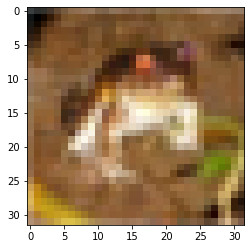

In [314]:
(X[0]/255).max()
plt.imshow(X[0])

In [315]:
def one_hot_encode(vec, vals=10):
    n=len(vec)
    out = np.zeros((n,vals))
    out[range(n), vec]= 1
    return out

In [316]:
class CifarHelper():
    def __init__(self):
        self.i=0
        self.all_train_batches= [data_batch_1,data_batch_2,data_batch_3,data_batch_4,data_batch_5,]
        self.test_batch=[test_batch]
        
        self.training_images= None
        self.training_labels= None
        
        self.test_images= None
        self.test_labels= None
    def set_up_images(self):
        print("setting up training Images and Labels")
        
        self.training_images= np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images= self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels= one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
    
        print ("setting up test Images and labels")
        
        self.test_images=np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)
        
    def next_batch(self, batch_size):
        x=self.training_images[self.i:self.i+batch_size].reshape(100, 32,32,3)
        y=self.training_labels[self.i:self.i+batch_size]
        self.i=(self.i+batch_size)% len(self.training_images)
        return x,y
        

In [317]:
ch = CifarHelper()
ch.set_up_images()
# batch =ch.next_batch(100)

setting up training Images and Labels
setting up test Images and labels


In [318]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

x= tf.compat.v1.placeholder(tf.float32,shape=[None, 32,32,3])
y_true= tf.compat.v1.placeholder(tf.float32,shape=[None,10])
hold_prob= tf.compat.v1.placeholder(tf.float32)

In [319]:
def init_weight(shape):
    init_random_dist= tf.compat.v1.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals= tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1],padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x,ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def convolution_layer(input_x, shape):
    W=init_weight(shape)
    b=init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,W)+b)

def normal_full_layer(input_layer,size):
    input_size= int(input_layer.get_shape()[1])
    W= init_weight([input_size, size])
    b=init_bias([size])
    return tf.matmul(input_layer, W)+b

In [320]:
convo_1= convolution_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [321]:
convo_2 = convolution_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [322]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

In [323]:
full_layer_one= tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [324]:
full_one_dropout=tf.compat.v1.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [325]:
y_pred=normal_full_layer(full_one_dropout,10)
y_pred

<tf.Tensor 'add_12:0' shape=(None, 10) dtype=float32>

In [326]:
# loss unction
cross_entropy= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [327]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [328]:
init = tf.compat.v1.global_variables_initializer()

In [329]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    
    for i in range(500):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob:0.5})
        
        if (i%100==0):
            print ("currently on step{}". format(i))
            print ("Accuracy is:")
            
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            
            acc= tf.reduce_mean(tf.cast(matches,tf.float32))
            
            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

currently on step0
Accuracy is:
0.1017


currently on step100
Accuracy is:
0.3971


currently on step200
Accuracy is:
0.4434


currently on step300
Accuracy is:
0.507


currently on step400
Accuracy is:
0.5212


